In [32]:
%pip install opencv-python torch torchvision torchaudio paho-mqtt ultralyticsplus ipywidgets

Note: you may need to restart the kernel to use updated packages.


In [33]:
import json
import time
import cv2
import numpy as np
import paho.mqtt.client as mqtt 
from ultralyticsplus import YOLO, render_result
from datetime import datetime
from IPython.display import display, Image as IPImage, clear_output
import ipywidgets as widgets
import torch

print("All libraries imported successfully!")

All libraries imported successfully!


### configuration mqtt 

In [34]:
# model 
MODEL_ID = "lewiswatson/yolov8x-tuned-hand-gestures"
CONF = 0.45 

# MQTT 
MQTT_BROKER = "broker.hivemq.com" 
MQTT_PORT = 1883
MQTT_TOPIC = "hand/gesture"  # Plain text payload 
MQTT_TOPIC_RAW = "hand/gesture/raw"    # full json payload
PUB_DELAY = 0.3 

# 0          = Default Webcam
# 1, 2, ...  = Other camera index
# "path/to/image.jpg" = Static image
# "path/to/video.mp4" = Video file
SOURCE = 0

print(f"MQTT  : {MQTT_BROKER}:{MQTT_PORT}")
print(f"Topics: {MQTT_TOPIC}  |  {MQTT_TOPIC_RAW}")
print(f"Source: {SOURCE}")
print(f"Conf  : {CONF}")

MQTT  : broker.hivemq.com:1883
Topics: hand/gesture  |  hand/gesture/raw
Source: 0
Conf  : 0.45


###### MQTT publish class

In [35]:
class MQTTPub:
    # Handles MQTT connection and pub
    def __init__(self, broker: str, port: int):
        self.broker = broker
        self.port = port
        self.CLI = mqtt.Client(client_id=f"hand-gesture-{int(time.time())}")
        self.CLI.on_connect = self._on_connect
        self.CLI.on_disconnect = self._on_disconnect
        self.connected = False
        self._last_pub = 0.0
        self.pub_count = 0
        self.log = [] #  history log
        
    def _on_connect(self, CLI, userData, flag, rc):
        if rc == 0:
            self.connected = True
            print(f"MQTT connected with {self.broker}:{self.port}")
        else:
            print(f"MQTT failed to connect rc={rc}")
        
    def _on_disconnect(self, CLI, userData, rc):
        self.connected = False
        print(f"MQTT Disconnected rc={rc}")
        
    def connect(self):
        print(f"MQTT Connecting to {self.broker}:{self.port}")
        self.CLI.connect(self.broker, self.port, keepalive=60)
        self.CLI.loop_start()
        time.sleep(1.5)
        return self.connected 
    
    def publish(self, gesture: str, conf: float, count: int) -> bool:
        now = time.time()
        if now - self._last_pub < PUB_DELAY:
            return False
        
        payload_simple = gesture 
        payload_full = json.dumps({
            "gesture" : gesture,
            "confidence" : round(conf, 3),
            "count" : count,
            "timestamp" : datetime.now().isoformat()
        })
        
        if self.connected:
            self.CLI.publish(MQTT_TOPIC, payload_simple, qos=1)
            self.CLI.publish(MQTT_TOPIC_RAW, payload_full, qos=1)
            self._last_pub = now 
            self.pub_count += 1
            entry = f"[#{self.pub_count}] {gesture} ({conf:.3f})"
            self.log.append(entry)
            return True
        return False
    
    def disconnect(self):
        self.CLI.loop_stop()
        self.CLI.disconnect()
        print(f"MQTT disconnected. Total Pub: {self.pub_count}")
        
print("MQTTPublisher class defined")


MQTTPublisher class defined


### load YOLOv8 model 

In [36]:
print(f"loading model: {MODEL_ID}")
print(" (First run will download ~136 MB for HuggingFace...)\n")

from functools import partial
torch.load = partial(torch.load, weights_only=False)

model = YOLO(MODEL_ID)
model.overrides["conf"] = CONF
model.overrides["iou"] = 0.45
model.overrides["max_det"] = 10

# print available gesture classes
classes = model.model.names if hasattr(model.model, 'name') else {}
print("\n Model loaded!")
print(f"Gesture classes: {list(classes.values()) if classes else 'see after first predict'}")

loading model: lewiswatson/yolov8x-tuned-hand-gestures
 (First run will download ~136 MB for HuggingFace...)



INFO:httpx:HTTP Request: GET https://huggingface.co/api/models/lewiswatson/yolov8x-tuned-hand-gestures/tree/main?recursive=true&expand=false "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: HEAD https://huggingface.co/lewiswatson/yolov8x-tuned-hand-gestures/resolve/main/weights/best.pt "HTTP/1.1 302 Found"



 Model loaded!
Gesture classes: see after first predict


#### connect to MQTT Broker 

In [39]:
pub = MQTTPub(MQTT_BROKER, MQTT_PORT)
connected = pub.connect() 

if connected:
    print(f"\n Subscribing tip:")
    print(f" Use MQTT Explorer -> broker.hivemq.com:1883")
    print(f" Subscribe {MQTT_TOPIC}/#") 
else:
    print(" Not connected - detection will still work, but no MQTT publish") 

/tmp/ipykernel_6809/4083548464.py:6: DeprecationWarning: Callback API version 1 is deprecated, update to latest version
  self.CLI = mqtt.Client(client_id=f"hand-gesture-{int(time.time())}")


MQTT Connecting to broker.hivemq.com:1883
MQTT connected with broker.hivemq.com:1883

 Subscribing tip:
 Use MQTT Explorer -> broker.hivemq.com:1883
 Subscribe hand/gesture/#


#### run on static lmage 

Runing inference on: ./2026-02-23-205822.jpg
Result print =  ultralytics.engine.results.Boxes object with attributes:

cls: tensor([18.], device='cuda:0')
conf: tensor([0.9356], device='cuda:0')
data: tensor([[567.5244, 424.0881, 718.9497, 720.0000,   0.9356,  18.0000]], device='cuda:0')
id: None
is_track: False
orig_shape: (720, 1280)
shape: torch.Size([1, 6])
xywh: tensor([[643.2371, 572.0441, 151.4253, 295.9119]], device='cuda:0')
xywhn: tensor([[0.5025, 0.7945, 0.1183, 0.4110]], device='cuda:0')
xyxy: tensor([[567.5244, 424.0881, 718.9497, 720.0000]], device='cuda:0')
xyxyn: tensor([[0.4434, 0.5890, 0.5617, 1.0000]], device='cuda:0')

 Found 1 gesture(s): 
 ✋ V                    conf=0.936


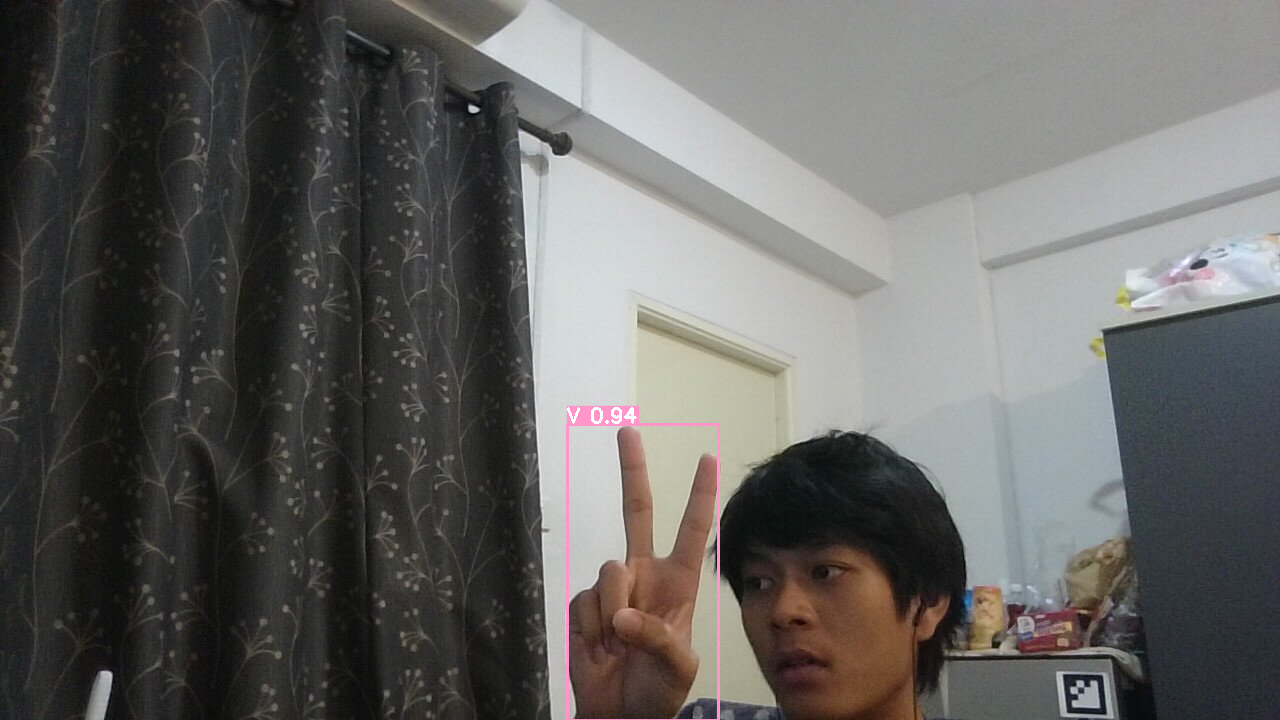

In [53]:
# IMG_SOURCE = "https://thumbs.dreamstime.com/b/young-man-showing-peace-sign-isolated-over-yellow-background-133210696.jpg"
IMG_SOURCE = "./2026-02-23-205822.jpg"
# IMG_SOURCE = "Your_photo.jpg" # local file

print(f"Runing inference on: {IMG_SOURCE}")

# predict 
results = model.predict(IMG_SOURCE, verbose=False)
result = results[0] 
print("Result print = ",result.boxes)

# extract detections 
detections = [] 
if result.boxes is not None:
    for i, cls_id in enumerate(result.boxes.cls.tolist()):
        name = result.names[int(cls_id)]
        conf = result.boxes.conf[i].item()
        detections.append({"gesture": name, "confidence": conf})

# print results 
print(f"\n Found {len(detections)} gesture(s): ")
for d in detections:
    icon = "✋"
    print(f" {icon} {d['gesture']:20s} conf={d['confidence']:.3f}")
    pub.publish(d["gesture"], d["confidence"], len(detections))
    
# Render annotated image 
render = render_result(model=model, image=IMG_SOURCE, result=results[0])
display(render)